# maher

In [1]:
from modeling import *
from data import get_data, cut_data
from predictions import *
import pandas as pd
from pystan.experimental import unpickle_fit

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
model = compile_or_load('stan/maher.stan')

In [4]:
data = cut_data(get_data(), '2018-01-01')
stan_data = prepare_stan_data(data)

/home/lukas/code/python/EM/data.py:30: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return df.loc[start_idx:]


In [5]:
fit = model.sampling(stan_data, control={'adapt_delta': .95}, iter=3000)


Gradient evaluation took 0.00058 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.8 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.0005 seconds
Gradient evaluation took 0.00051 seconds
1000 transitions using 10 leapfrog steps per transition would take 5 seconds.
1000 transitions using 10 leapfrog steps per transition would take 5.1 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 0.000467 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.67 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 3000 [  0%]  (Warmup)
Iteration:    1 / 3000 [  0%]  (Warmup)
Iteration:    1 / 3000 [  0%]  (Warmup)
Iteration:    1 / 3000 [  0%]  (Warmup)
Iteration:  300 / 3000 [ 10%]  (Warmup)
Iteration:  300 / 3000 [ 10%]  (Warmup)
Iteration:  300 / 3000 [ 10%]  (Warmup)
Iteration:  300 / 3000 [ 10%]  (Warmup)
Iteration:  600 / 3000 [ 20%]  (W

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [125]:
with open('/home/data/EM_fits/maher_no_hier_2016-01-01.pic', 'wb') as f:
    pickle.dump(fit, f, -1)

<ipython-input-125-8fde3f0f0465>:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f, -1)


In [4]:
fit = unpickle_fit('/home/data/EM_fits/maher_no_hier_2016-01-01.pic')

In [6]:
countries = get_country_list(data)
chains = fit.extract()
attack = pd.DataFrame(chains['attack'], columns=countries)
defense = pd.DataFrame(chains['defense'], columns=countries)
intercept = chains['intercept']
home_advantage = chains['home_advantage']

In [3]:
matches = pd.read_csv('matches/pre_day1.csv', header=0)

In [4]:
matches

,home_team,away_team,location
0,Turkey,Italy,Italy
1,Wales,Switzerland,Azerbaijan
2,Denmark,Finland,Denmark
3,Belgium,Russia,Russia
4,England,Croatia,England
5,Austria,North Macedonia,Romania
6,Netherlands,Ukraine,Netherlands
7,Scotland,Czech Republic,Scotland
8,Poland,Slovakia,Russia
9,Spain,Sweden,Sweden


In [7]:
def predict_outcomes_poisson(
    attack,
    defense,
    home_advantage,
    intercept,
    location,
    countries
):
    log_rate_home = (intercept + attack[countries[0]] - defense[countries[1]])
    log_rate_away = (intercept + attack[countries[1]] - defense[countries[0]])
    if countries[0] == location:
        log_rate_home += home_advantage
    elif countries[1] == location:
        log_rate_away += home_advantage
    rates = np.exp(np.stack([log_rate_home, log_rate_away], axis=1))
    predicted_outcomes = poisson(rates).rvs()
    results, counts = count_results(predicted_outcomes)
    return counts_to_matrix(results, counts)


In [13]:
A = predict_outcomes_poisson(attack, defense, home_advantage, intercept, 'Qatar', ['Senegal', 'Netherlands'])

/home/lukas/miniconda3/envs/bafeg_clean/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


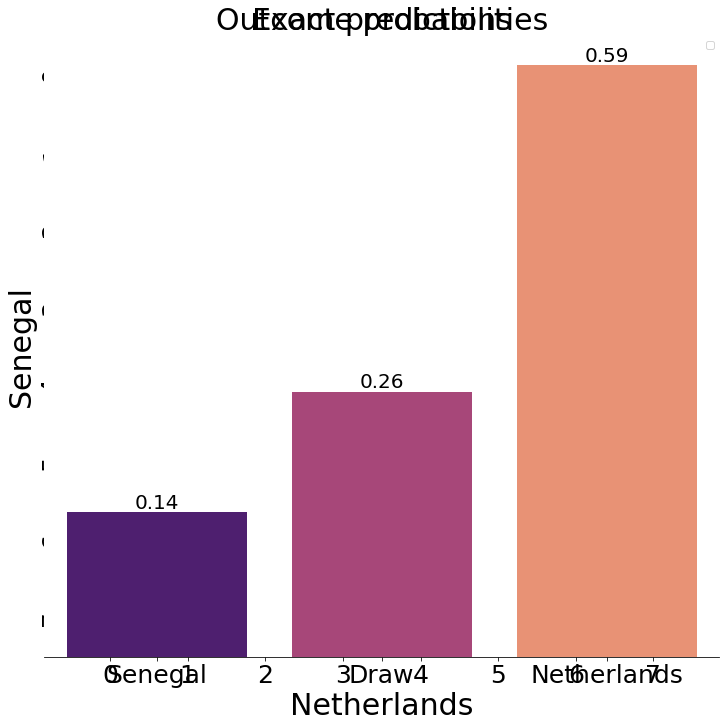

In [16]:
plot_goal_predictions(A, 'Senegal', 'Netherlands')



/home/lukas/miniconda3/envs/bafeg_clean/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


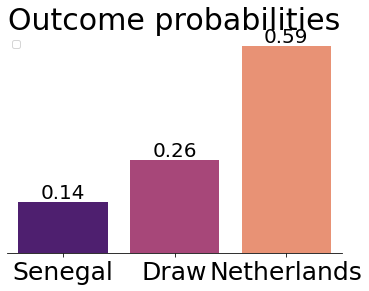

In [17]:
plot_outcome_prob(A, 'Senegal', 'Netherlands')

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import matplotlib.patheffects as PathEffects

In [9]:
def plot_goal_predictions(A, home_team, away_team, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
    sns.heatmap(A, cmap='magma', cbar=False, ax=ax)
    x_max, y_max = A.shape;
    for x, y in product(range(x_max), range(y_max)):
        txt = ax.text(
            y + .5, x + .5, str(A[x,y].round(3)),
            ha='center', va='center', color='w', size=20
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
    ax.set_aspect('equal')
    ax.set_xlabel(away_team, fontsize=30)
    ax.set_ylabel(home_team, fontsize=30)
    ax.set_xticks(np.arange(A.shape[1]) + .5)
    ax.set_xticklabels(np.arange(A.shape[1]), fontsize=25)
    ax.set_yticks(np.arange(A.shape[0]) + .5)
    ax.set_yticklabels(np.arange(A.shape[0]), fontsize=25)
    ax.set_title('Exact predictions', fontsize=30)
    if ax is None:
        return fig

In [10]:
def plot_outcome_prob(A, home_team, away_team, ax=None):
    p_home = np.tril(A, -1).sum()
    p_away = np.triu(A, 1).sum()
    p_draw = np.diag(A).sum()
    x = np.arange(3)
    y = np.array([p_home, p_draw, p_away])
    if ax is None:
        ax = plt.axes()
    sns.barplot(x, y, hue=y, palette='magma', dodge=False, ax=ax)
    ax.legend('')
    ax.set_xticks(x)
    ax.set_yticks([])
    ax.set_xticklabels([home_team, 'Draw', away_team], fontsize=25)
    ax.set_title('Outcome probabilities', fontsize=30)
    for i, p in enumerate(y):
        ax.text(i, p, str(p.round(2)), ha='center', va='bottom', fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [11]:
def plot_full_predictions(A, home_team, away_team, cutoff=5):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), constrained_layout=True)
    plot_goal_predictions(A[:cutoff + 1, :cutoff + 1], home_team, away_team, ax=axs[0])
    plot_outcome_prob(A, home_team, away_team, ax=axs[1])
    return fig

In [29]:
predictions[10]

['Hungary',
 'Portugal',
 array([[0.0705    , 0.13866667, 0.1415    , 0.08983333, 0.04483333,
         0.019     , 0.00766667, 0.0025    , 0.00033333, 0.        ,
         0.00016667],
        [0.04833333, 0.089     , 0.09616667, 0.055     , 0.03366667,
         0.01366667, 0.00483333, 0.00166667, 0.0005    , 0.        ,
         0.        ],
        [0.0175    , 0.02783333, 0.03216667, 0.01583333, 0.01083333,
         0.0045    , 0.00166667, 0.00066667, 0.        , 0.        ,
         0.        ],
        [0.004     , 0.00583333, 0.006     , 0.00583333, 0.003     ,
         0.0005    , 0.        , 0.00016667, 0.        , 0.        ,
         0.        ],
        [0.0005    , 0.001     , 0.00116667, 0.0015    , 0.00033333,
         0.00066667, 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.00033333, 0.        , 0.        , 0.00016667, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.    

In [33]:
A=predictions[10][-1]

In [34]:
A.argmax()

2

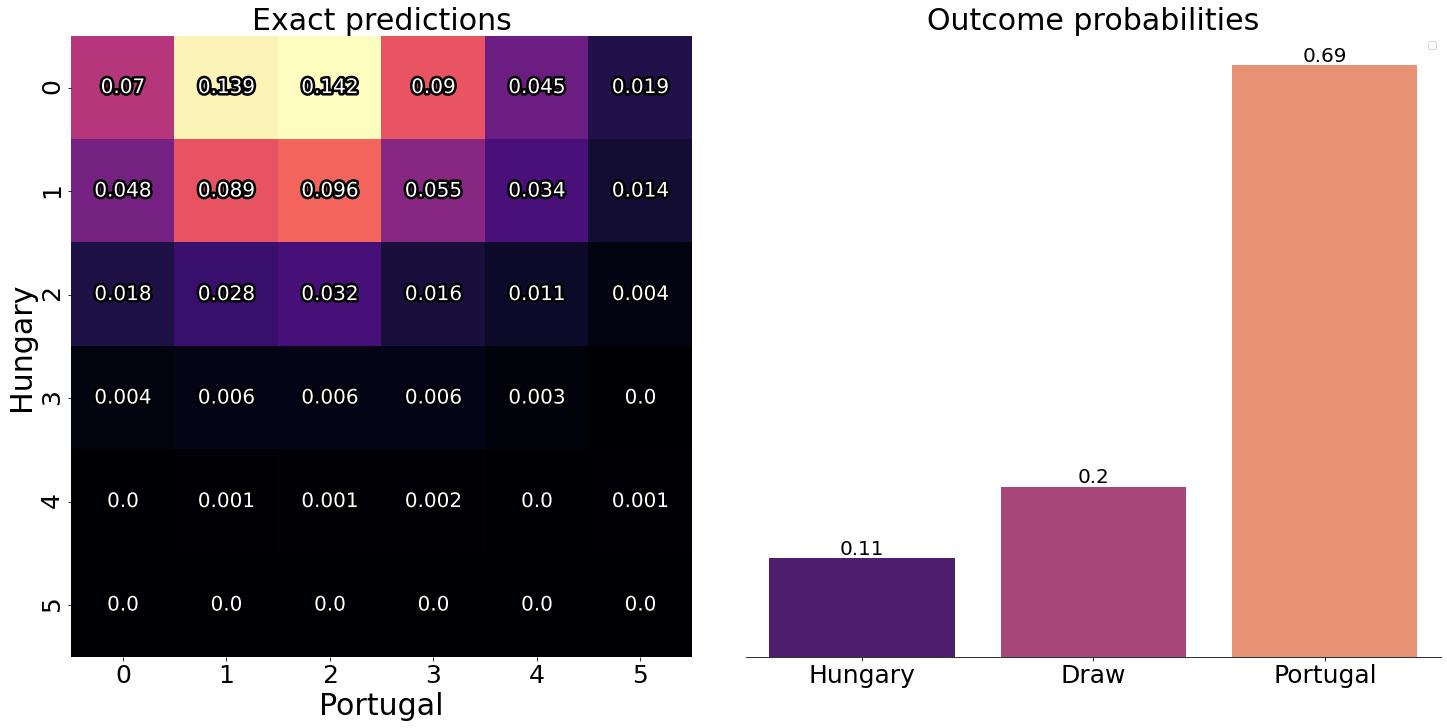

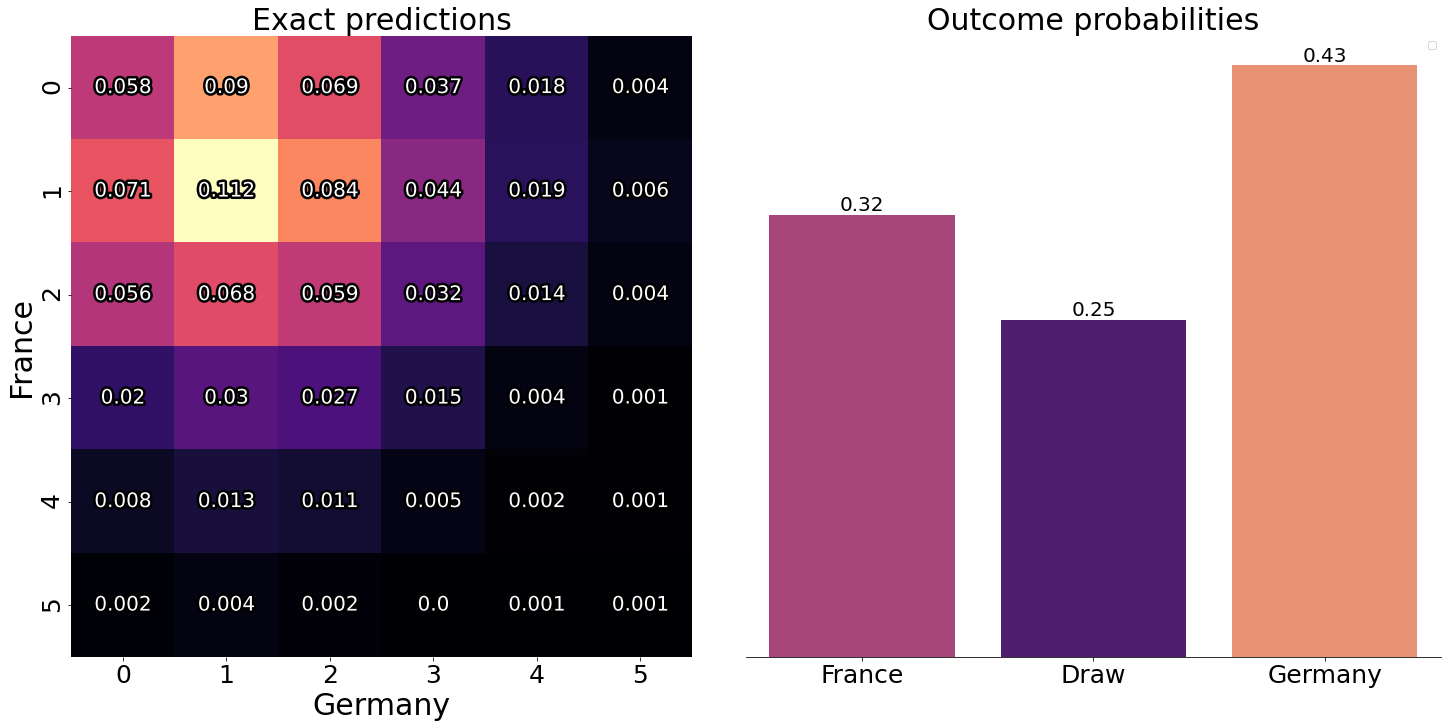

In [39]:
for i in range(10, 12):
    home_team, away_team, A = predictions[i]
    fig = plot_full_predictions(A, home_team, away_team);
    fig.savefig(home_team + '-' + away_team + '.png', facecolor='white', transparent=False)

In [168]:
A

array([[0.0605    , 0.04383333, 0.01566667, 0.00366667, 0.0005    ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.12433333, 0.09166667, 0.03133333, 0.00816667, 0.0015    ,
        0.0005    , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.12283333, 0.098     , 0.03366667, 0.00916667, 0.0015    ,
        0.00016667, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.089     , 0.0585    , 0.02483333, 0.007     , 0.00233333,
        0.00016667, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.0445    , 0.033     , 0.014     , 0.00483333, 0.00133333,
        0.00016667, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.02266667, 0.017     , 0.005     , 0.00183333, 0.0005    ,
        0.00016667, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.009     , 0.00433333, 0.00233333, 0.001     , 0.

In [119]:
fig.savefig('austria-croatia.png', facecolor='white', transparent=False)

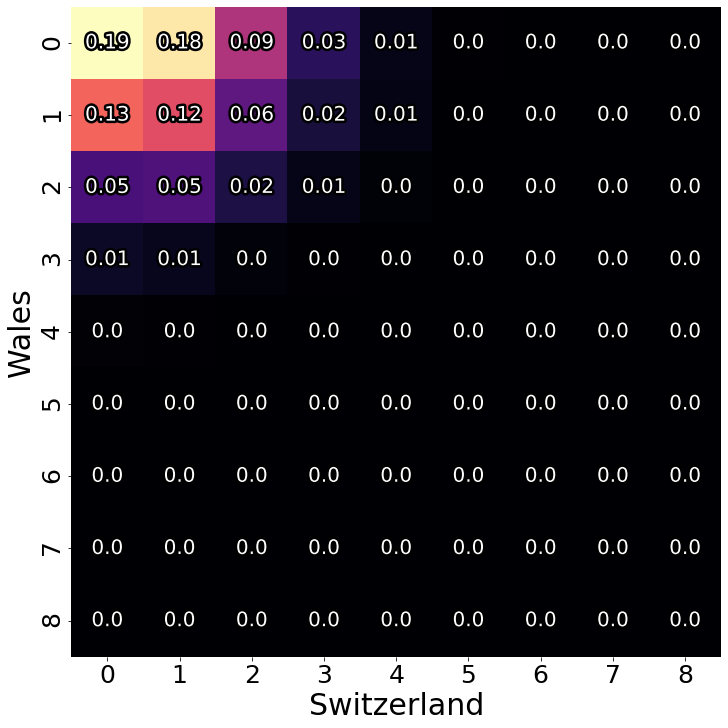

In [56]:
home_team, away_team, A = predictions[1]
plot_goal_predictions(A, home_team, away_team)

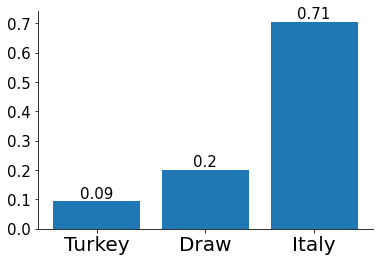

In [162]:
plt.bar([0,1,2], [p_h, p_d, p_a])
for i, p in enumerate([p_h, p_d, p_a]):
    plt.text(i, p, str(p.round(2)), ha='center', va='bottom', fontsize=15)
plt.xticks([0,1,2], ['Turkey', 'Draw', 'Italy'], fontsize=20)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


Text(0.5, 1.0, 'Outcome probabilities')

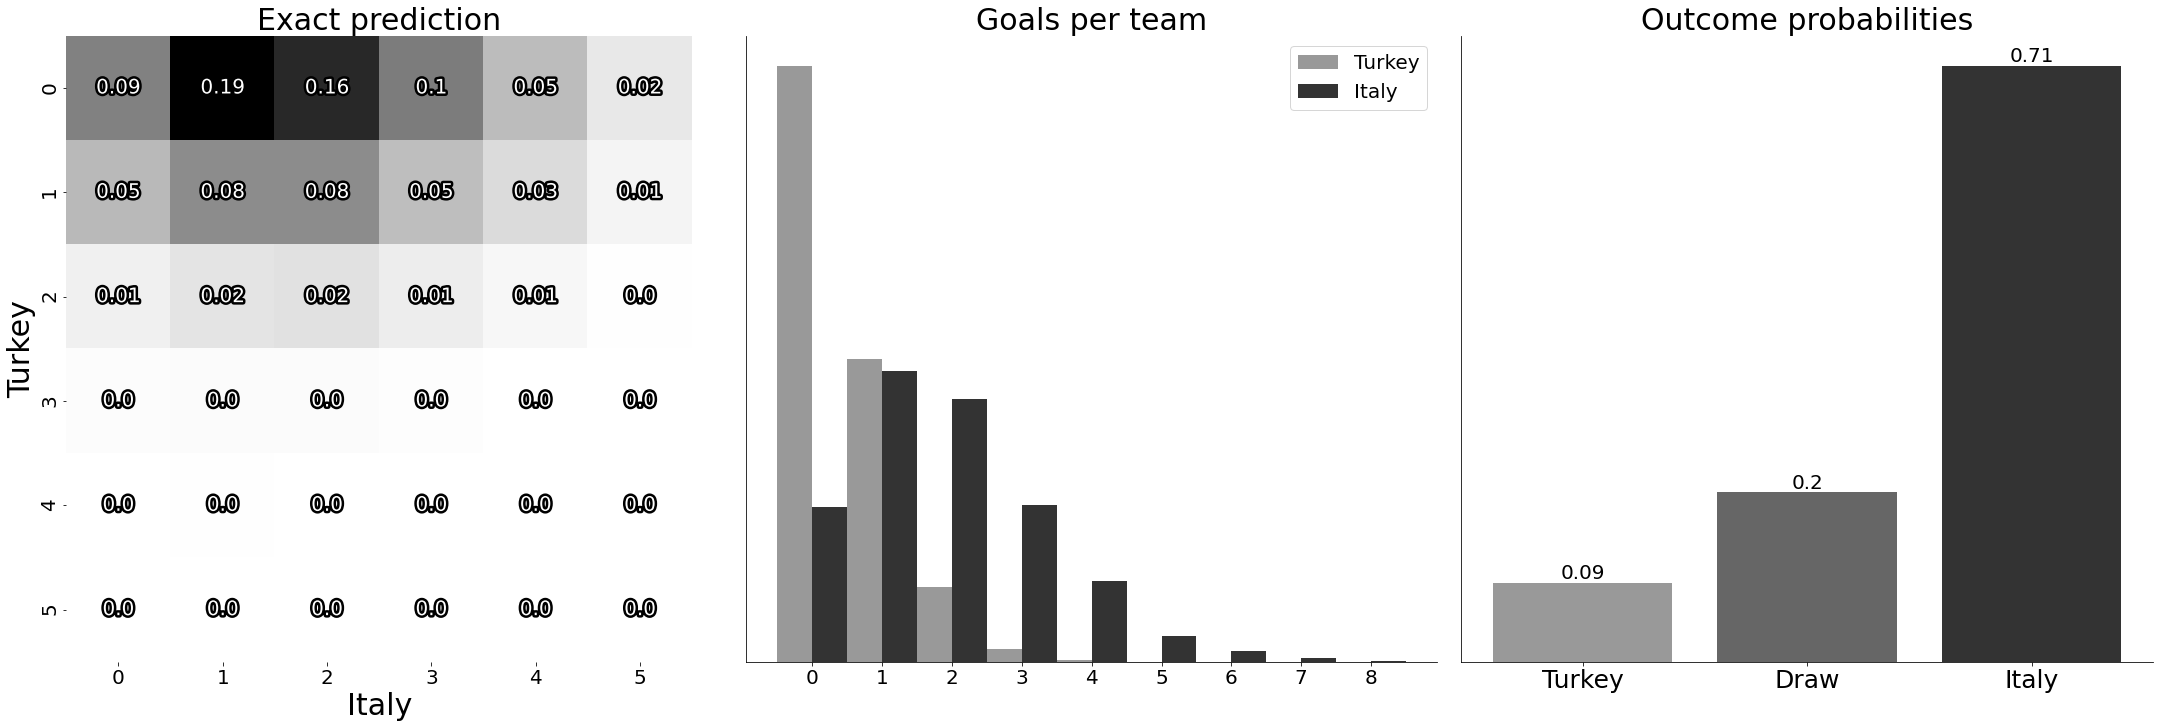

In [270]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 10), constrained_layout=True)
plot_goal_predictions(A[:6, :6], 'Turkey', 'Italy', ax=axs[0])
axs[0].set_title('Exact prediction', fontsize=30)
axs[0].set_xticklabels(np.arange(6),fontsize=20)
axs[0].set_yticklabels(np.arange(6),fontsize=20)
axs[1].bar(np.arange(9) - .25, A.sum(axis=1), alpha=.4, color='k', width=.5, label='Turkey')
axs[1].bar(np.arange(9) + .25, A.sum(axis=0), alpha=.8, color='k', width=.5, label='Italy')
axs[1].set_title('Goals per team', fontsize=30)
axs[1].legend(fontsize=20)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(np.arange(9))
axs[1].set_xticklabels(np.arange(9),fontsize=20)
axs[1].set_yticks([])
axs[2].bar(0, p_h, alpha=.4, color='k')
axs[2].bar(2, p_a, alpha=.8, color='k')
axs[2].bar(1, p_d, alpha=.6, color='k')

for i, p in enumerate([p_h, p_d, p_a]):
    axs[2].text(i, p, str(p.round(2)), ha='center', va='bottom', fontsize=20)
plt.xticks([0,1,2], ['Turkey', 'Draw', 'Italy'], fontsize=25)
plt.yticks([])
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_title('Outcome probabilities', fontsize=30)

In [272]:
fig.savefig('italy_turkey_full.png')

In [184]:
A.sum(axis=0)

array([0.157  , 0.29475, 0.26625, 0.1585 , 0.08175, 0.026  , 0.01125,
       0.0035 , 0.001  ])

In [185]:
A.sum(axis=1)

array([0.6035 , 0.30675, 0.07525, 0.0125 , 0.002  , 0.     , 0.     ,
       0.     , 0.     ])

In [138]:
p_mats = []
for home_team, away_team, location in matches.values:
    pred = predict_outcomes_poisson(attack, defense, home_advantage, intercept, location, [home_team, away_team])
    results, prob = count_results(pred)
    print(home_team, away_team, results[prob.argmax()])
    p_mats.append([home_team, away_team, counts_to_matrix(results, prob)])

Turkey Italy [0 1]
Wales Switzerland [0 0]
Denmark Finland [1 0]
Belgium Russia [2 1]
England Croatia [2 0]
Austria North Macedonia [1 0]
Netherlands Ukraine [2 0]
Scotland Czech Republic [1 1]
Poland Slovakia [1 0]
Spain Sweden [1 0]
Hungary Portugal [0 1]
France Germany [1 1]


In [134]:
from itertools import product
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [261]:
def plot_goal_predictions(A, home_team, away_team, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
    sns.heatmap(A, cmap='gray', cbar=False, ax=ax)
    x_max, y_max = A.shape;
    for x, y in product(range(x_max), range(y_max)):
        txt = ax.text(
            y + .5, x + .5, str(A[x,y].round(2)),
            ha='center', va='center', color='w', size=10
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
    ax.set_aspect('equal')
    ax.set_xlabel(away_team, fontsize=20)
    ax.set_ylabel(home_team, fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    if ax is None:
        return fig